In [213]:
#import key packageskeras.utils.plot_model(model, "my_first_model.png")

import os
import sys
import numpy as np
import pandas as pd 

from sklearn.linear_model import TweedieRegressor
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats

from tensorflow import keras
from tensorflow.keras import layers

In [214]:
# DATA MINING

df = pd.read_csv("gefcom.csv") 
#print(data.head())
#print(data.tail())

## select data
df_tot = df[df['zone']=='TOTAL']
df_2 = df_tot[(df_tot['year']>=2009) & (df_tot['year']<=2016)] # ricordare di cambiare date 2011 -> 2016

#print(df_2.head())
#print(df_2.tail())


## create a DataFrame
date = df_2['date'].unique()
demand = np.zeros(len(date))
drybulb = np.zeros(len(date))
dewpnt = np.zeros(len(date))
year = np.zeros(len(date))
month = ['']*(len(date))
day_of_week = ['']*(len(date))
holiday = np.zeros(len(date),dtype=bool)
for n in range(len(date)):
    demand[n] = sum(df_2[df_2['date']==date[n]].demand)
    drybulb[n] = np.mean(df_2[df_2['date']==date[n]].drybulb)
    dewpnt[n] = np.mean(df_2[df_2['date']==date[n]].dewpnt)
    y = (df_2[df_2['date']==date[n]].year)
    year[n] = int(y.iloc[0])
    m = (df_2[df_2['date']==date[n]].month)
    month[n] = m.iloc[0]
    d = (df_2[df_2['date']==date[n]].day_of_week)
    day_of_week[n] = d.iloc[0]
    h = (df_2[df_2['date']==date[n]].holiday)
    holiday[n] = h.iloc[0]

df_years = pd.DataFrame({'date': date,
'demand': demand,
'drybulb': drybulb,
'dewpnt': dewpnt,
'year': year,
'month': month,
'day_of_week': day_of_week,
'holiday': holiday})
#data3 = pd.DataFrame({'date': date,'demand': demand,'drybulb': drybulb,'dewpnt': dewpnt,'year': year,'month': month,'day_of_week': day_of_week,'holiday': holiday})



In [215]:
print(df_years)

date      demand    drybulb     dewpnt    year month day_of_week  \
0     2009-01-01  378241.000   9.328125  -6.442708  2009.0   Jan         Thu   
1     2009-01-02  382147.000  19.203125   8.161458  2009.0   Jan         Fri   
2     2009-01-03  353372.000  25.286458  12.109375  2009.0   Jan         Sat   
3     2009-01-04  350325.000  24.348958   9.713542  2009.0   Jan         Sun   
4     2009-01-05  373321.000  31.557292  21.770833  2009.0   Jan         Mon   
...          ...         ...        ...        ...     ...   ...         ...   
2917  2016-12-27  320689.678  46.901042  37.973958  2016.0   Dec         Tue   
2918  2016-12-28  336295.380  34.572917  21.296875  2016.0   Dec         Wed   
2919  2016-12-29  352193.506  31.260417  25.833333  2016.0   Dec         Thu   
2920  2016-12-30  334376.464  32.916667  22.177083  2016.0   Dec         Fri   
2921  2016-12-31  329143.334  29.713542  19.067708  2016.0   Dec         Sat   

      holiday  
0        True  
1       False  
2  

In [216]:

df_stand = df_years 
# [2] correction
N_df = len(df_stand.demand)
df_stand.demand = (df_stand.demand-[min(df_stand.demand)]*len(df_stand.demand))/(max(df_stand.demand)-min(df_stand.demand)) + [0.001]*len(df_stand.demand)
print(df_stand.demand)
print(np.mean(df_stand.demand))

0       0.445534
1       0.458702
2       0.361697
3       0.351425
4       0.428948
          ...   
2917    0.251520
2918    0.304129
2919    0.357724
2920    0.297660
2921    0.280018
Name: demand, Length: 2922, dtype: float64
0.3316193982405473


In [217]:
# BUILD THE REGRESSORS

first_year = 2009
train_year = 2011

data = df_stand[(df_stand['year']>=2009) & (df_stand['year']<=train_year)]

log_consumption = np.log(data.demand)
omega = 2*np.pi/365
D_weekend = pd.get_dummies(data.day_of_week)
D_holiday = pd.get_dummies(data.holiday)
time_in_days = range(len(data))

# FIRST DAY IS march 1st, lacking 59 calendar days  6 years from 2003 to before 2009 6*365-59 number of days until 2009
time_since_dataset = (first_year-2004)*365-59

t=( np.array(time_in_days)+time_since_dataset )
# covariates
X=[t,np.sin(omega*t),np.cos(omega*t),np.sin(2*omega*t),np.cos(2*omega*t),D_weekend.Sat, D_weekend.Sun, D_holiday.iloc[:,1]] # manca hol
X = np.transpose(X)
#print(X)

In [219]:
# BASIC LINEAR REGRESSION

reg = LinearRegression()
reg.fit(X,log_consumption)
print('Linear')
print(reg.intercept_)
print(reg.coef_)
reg.score(X,log_consumption)

Linear
-1.2022176105375497
[ 7.60948769e-05 -2.92317965e-02 -5.54458770e-02 -3.88774223e-01
  1.24302906e-01 -3.66991453e-01 -5.12606138e-01 -2.62462882e-01]


0.625805541440247

In [220]:
Xnew = [np.ones(len(X)),t,np.sin(omega*t),np.cos(omega*t),np.sin(2*omega*t),np.cos(2*omega*t),D_weekend.Sat, D_weekend.Sun, D_holiday.iloc[:,1]]
Xnew = np.transpose(Xnew)

gauss_log = sm.GLM(data.demand, Xnew, family=sm.families.Gaussian(sm.families.links.log))
gauss_log_results = gauss_log.fit()
param_new=gauss_log_results.params

In [221]:
# BETA DEL PROF
beta = [0.385, -0.000016, -0.003, -0.028, 0.136, -0.043, -0.146, -0.120, -0.060]

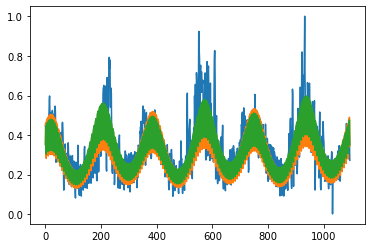

In [222]:
# PLOT GLM
plt.figure()


data.demand.plot()
inter = pd.Series(np.exp(np.array([reg.intercept_]*len(X))+np.dot(X,reg.coef_)))
inter.plot()

internew = pd.Series(np.exp(np.array(np.dot(Xnew,param_new))))
internew.plot()

plt.show()



In [223]:
#custom loss function
def custom_loss(y_true, y_pred):
    
    # calculate loss, using likehood function for residual Rt

    mean = y_pred[0]
    var = (y_pred[1])**2 
    loss = np.exp(-(y_true-mean)**2 /(2*var) ) / (2*np.pi*var)**.5
        
    return -10**3*tf.reduce_mean(np.log(loss), axis=-1)

In [224]:
#optimizer 
learn_rate = 0.1 #,.01, .003, .001
hidden_neurons = 6 # 3,4,5 
n_batch = 50 #none
act_f = "softmax" #'sigmoid'
reg_param = .001 #.0001, 0

In [225]:
data.head()

,date,demand,drybulb,dewpnt,year,month,day_of_week,holiday
0,2009-01-01,0.445534,9.328125,-6.442708,2009.0,Jan,Thu,True
1,2009-01-02,0.458702,19.203125,8.161458,2009.0,Jan,Fri,False
2,2009-01-03,0.361697,25.286458,12.109375,2009.0,Jan,Sat,False
3,2009-01-04,0.351425,24.348958,9.713542,2009.0,Jan,Sun,False
4,2009-01-05,0.428948,31.557292,21.770833,2009.0,Jan,Mon,False


In [165]:
input_size = 10
output_states=2
look_back = 1


In [166]:
X = [data['drybulb'], data['dewpnt'], t, np.sin(omega*t), np.cos(omega*t), np.sin(2*omega*t), np.cos(2*omega*t),D_weekend.Sat, D_weekend.Sun, D_holiday.iloc[:,1]]


x_train= np.transpose(X)

len((x_train))

1095

In [172]:
y_train = np.array(data['demand'])


In [194]:
model = keras.models.Sequential()

# NOT USED
act_reg = keras.regularizers.l1 (reg_param)

In [195]:
model.add(layers.LSTM ( 5 , input_shape=(input_size, look_back), return_sequences=True ))

In [196]:
# SIMPLE LSTM MODEL
model.add(layers.Dense(output_states))

# Optimizer
opt = keras.optimizers.Adam(learning_rate=learn_rate)
model.compile(loss='mae', optimizer=opt)

In [197]:
	
# FIT
model.fit(x_train, y_train, epochs=150, batch_size=n_batch , verbose=1)

Epoch 1/150


ValueError: in user code:

    C:\Users\konra\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\keras\engine\training.py:571 train_function  *
        outputs = self.distribute_strategy.run(
    C:\Users\konra\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\konra\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\konra\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\konra\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\keras\engine\training.py:531 train_step  **
        y_pred = self(x, training=True)
    C:\Users\konra\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:885 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    C:\Users\konra\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:176 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_10 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: [None, 10]
